# Tutorial: QCTSP論文対応: Hawkes実装の回路・数式マッピング

Audience:
- QCTSP論文（Quantum Encoding and Analysis on CTSP）を読みつつ、実装との対応を確認したい読者。

Prerequisites:
- 連続時間確率過程の基本（Poisson / Markov / Hawkes）
- Qiskitの基礎（QuantumCircuitの読み書き）
- Python / NumPy の基礎

Learning goals:
- 論文の「保持時間表現（Holding Time Representation）」が実装のどの構造に対応するか説明できる。
- 指数分布の離散化と p(τ|X) がどの式に対応するか説明できる。
- Hawkesの遷移（η更新）が QCTSP の遷移表にどう載るか説明できる。
- 情報抽出（積分評価）の矩形近似が実装と一致することを確認できる。


## Outline

1. セットアップ
2. Section 2 (Definition 2/3, Eq. (1)-(2)) と実装の対応
3. Section 3 (指数分布の保持時間) と離散化の対応
4. Section 3 (Markov/遷移) と Hawkes の状態遷移表
5. QCTSP-P (回路準備) のミニ回路図
6. Section 4 (情報抽出/積分) と実装の指標
7. 演習 + Pitfalls / Extensions


In [2]:
# セットアップ（このノートブックはリポジトリルートで実行する想定）
from __future__ import annotations

from pathlib import Path
import sys
import numpy as np

ROOT = Path.cwd()
if (ROOT / "src").exists():
    sys.path.append(str(ROOT / "src"))

np.random.seed(7)

from qctsp.qctsp_hawkes.discretization import (
    build_eta_grid,
    build_tau_edges,
    tau_bin_representative_midpoint,
    tau_bin_representative_condexp,
)
from qctsp.qctsp_hawkes.transition_tables import (
    build_p_tau_given_x,
    build_transition_table,
)
from qctsp.qctsp_hawkes.circuits.unroll import build_qctsp_unroll_circuit
from qctsp.validation.metrics import integral_eta_rect, integral_lambda_rect


## 1. Section 2: 保持時間表現（Definition 2 / Eq. (1)-(2)）と実装

論文の保持時間表現では、連続時間過程を「不変区間の列」として表現します：

\[
X(t)=X_j \quad (T_{j-1} \le t < T_j),\quad \tau_j = T_j - T_{j-1}.
\]

そして QCTSP 状態は

\[
|\psi\rangle = \sum_{k,t} p(k,t) |k, x(k), t\rangle
\]

と書かれ、確率は Eq. (2) のように条件付き分解されます。

### 実装上の対応
- **状態空間**: `eta_grid = build_eta_grid(S, eta_max)`
- **保持時間の離散化**: `tau_edges = build_tau_edges(R, tau_max, ...)`
- **条件付き保持時間**: `p_tau_given_x = build_p_tau_given_x(eta_grid, tau_edges, mu, alpha)`

次のセルで、最小例の離散化結果を確認します。


In [3]:
S, R = 4, 6
mu, alpha = 0.8, 0.6
eta_max, tau_max = 4.0, 3.0

eta_grid = build_eta_grid(S=S, eta_max=eta_max)
tau_edges = build_tau_edges(R=R, tau_max=tau_max, mode="linear")

p_tau_given_x = build_p_tau_given_x(
    eta_grid=eta_grid,
    tau_edges=tau_edges,
    mu=mu,
    alpha=alpha,
)

np.set_printoptions(precision=3, suppress=True)
print("eta_grid:", eta_grid)
print("tau_edges:", tau_edges)
print("row sums:", p_tau_given_x.sum(axis=1))


eta_grid: [0.    1.333 2.667 4.   ]
tau_edges: [0.  0.6 1.2 1.8 2.4 3.  inf]
row sums: [1. 1. 1. 1.]


## 2. Section 3: 保持時間の指数分布（Theorem 1, Appendix B.1）と離散化

論文では memory-less（ML=0）の場合、保持時間は指数分布：

\[
P(\tau \ge t) = e^{-\lambda t}
\]

であり、離散化するとビン確率は

\[
P(\tau \in [e_r, e_{r+1})) = e^{-\lambda e_r} - e^{-\lambda e_{r+1}},
\]

最後のビンが \([e_{R-1}, \infty)\) のときは

\[
P(\tau \ge e_{R-1}) = e^{-\lambda e_{R-1}}.
\]

### 実装上の対応
- `build_tau_edges(..., mode="exp-quantile")`: 指数分布の分位点でビンを作る
- `tau_bin_representative_midpoint`: 代表値を中点で取る
- `tau_bin_representative_condexp`: 条件付き期待値 \(E[\tau\mid \tau\in \text{bin}]\)

次のセルで midpoint と condexp の違いを確認します。


In [4]:
rate = 1.2
edges = build_tau_edges(R=6, tau_max=3.0, mode="exp-quantile", lambda_ref=rate)
repr_mid = tau_bin_representative_midpoint(edges)
repr_cond = tau_bin_representative_condexp(edges, rate=rate)

print("edges:", edges)
print("midpoint repr:", repr_mid)
print("condexp repr:", repr_cond)
print("condexp in-bin?", [float(a <= v <= b) for a, b, v in zip(edges[:-1], edges[1:], repr_cond)])


edges: [0.    0.18  0.411 0.73  1.255 3.      inf]
midpoint repr: [0.09  0.295 0.57  0.992 2.127 3.873]
condexp repr: [0.087 0.29  0.56  0.965 1.843 3.833]
condexp in-bin? [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## 3. Section 3: Markov遷移と Hawkes の状態更新

論文の連続時間Markov過程（Fig. 5）の構造では、
\(X_{j+1}\) は直前の \(X_j\) に依存し、\(\tau_j\) は現在の状態に依存します。

Hawkes (exp kernel) の場合、

\[
\lambda(t)=\mu+\alpha\eta(t),\quad
\eta(t)=\sum_{t_i < t} e^{-\beta (t - t_i)}.
\]

保持時間表現で区間 \(\tau_j\) が与えられると、

\[
\eta_{j+1} = \eta_j e^{-\beta \tau_j} + 1
\]

となり、これを離散化した遷移表が `build_transition_table` です。


In [5]:
beta = 1.5
eta_grid = build_eta_grid(S=8, eta_max=6.0)

# tau代表値（中点）
tau_edges = build_tau_edges(R=8, tau_max=3.0, mode="linear")
tau_mid = tau_bin_representative_midpoint(tau_edges)

trans = build_transition_table(
    eta_grid=eta_grid,
    tau_mid=tau_mid,
    alpha=alpha,
    beta=beta,
)

print("transition table shape:", trans.shape)
print("first row:", trans[0])


transition table shape: (8, 8)
first row: [1 1 1 1 1 1 1 1]


## 4. QCTSP-P（回路準備）のミニ回路図

論文の QCTSP 準備（Problem 1 / Section 3）では、

- **U**: 状態 \(X_j\) の準備
- **V**: 条件付きで \(\tau_j\) を準備

という構造を持ちます。

本実装では、lookup に基づく簡易回路で

- `append_conditional_tau_preparation` が **V** に相当
- `append_transition_update` が **U** に相当

の役割を果たします。次のセルで小規模な回路図を表示します。


In [6]:
from qctsp.qctsp_hawkes.transition_tables import build_p_tau_given_x

S, R, n_steps = 4, 4, 2
mu, alpha, beta = 0.8, 0.6, 1.2
eta_grid = build_eta_grid(S=S, eta_max=4.0)

edges = build_tau_edges(R=R, tau_max=2.0, mode="linear")
repr_mid = tau_bin_representative_midpoint(edges)

p_tau = build_p_tau_given_x(eta_grid=eta_grid, tau_edges=edges, mu=mu, alpha=alpha)
trans = build_transition_table(eta_grid=eta_grid, tau_mid=repr_mid, alpha=alpha, beta=beta)

circuit, layout = build_qctsp_unroll_circuit(
    p_tau_given_x=p_tau,
    transition_table=trans,
    n_steps=n_steps,
    x0=0,
    measure_x_path=True,
)

try:
    from qiskit.visualization import circuit_drawer
    from IPython.display import display

    display(circuit_drawer(circuit, output="mpl"))
except Exception:
    print(circuit.draw(output="text"))


       ┌───┐                                                       ┌───┐     »
 x0_0: ┤ X ├───────────────────────────■───────────────────────────┤ X ├─────»
       ├───┤                           │                           ├───┤┌───┐»
 x0_1: ┤ X ├───────────────────────────■───────────────────────────┤ X ├┤ X ├»
       └───┘                           │                           └───┘└───┘»
 x1_0: ────────────────────────────────┼─────────────────────────────────────»
                                       │                                     »
 x1_1: ────────────────────────────────┼─────────────────────────────────────»
                                       │                                     »
 x2_0: ────────────────────────────────┼─────────────────────────────────────»
                                       │                                     »
 x2_1: ────────────────────────────────┼─────────────────────────────────────»
            ┌──────────────────────────┴────────────

## 5. Section 4: 情報抽出（積分評価）の矩形近似

論文では、保持時間表現により

\[
I(X,T)=\int_0^T X(t)\,dt \approx \sum_j X_j\,\tau_j
\]

という矩形和に落とせると説明しています（Eq. (6), Appendix C.1 Eq. (24)）。

Hawkesでは \(X\) を \(\eta\) とみなすと、

\[
I_\eta \approx \sum_j \eta_j\tau_j,
\quad
I_\lambda \approx \sum_j (\mu+\alpha\eta_j)\tau_j.
\]

実装では `integral_eta_rect`, `integral_lambda_rect` がこの矩形近似に対応します。


In [7]:
eta_seq = np.array([0.0, 1.2, 0.7])
tau_seq = np.array([0.3, 0.4, 0.5])

I_eta = integral_eta_rect(eta_seq=eta_seq, tau_seq=tau_seq)
I_lambda = integral_lambda_rect(mu=0.8, alpha=0.6, eta_seq=eta_seq, tau_seq=tau_seq)

print("I_eta:", I_eta)
print("I_lambda:", I_lambda)


I_eta: 0.83
I_lambda: 1.4580000000000002


## 6. ミニ・パイプライン（QCTSPサンプル → N(T)）

論文の流れでは、QCTSP から統計量を抽出する「情報抽出」の部分に該当します。
ここでは量子回路実行ではなく、**同じルックアップ表を使った古典サンプリング**で
保持時間列から \(N(T)\) を計算します。


In [8]:
from qctsp.qctsp_hawkes.circuits.unroll import sample_qctsp_classically

T = 3.0
samples = sample_qctsp_classically(
    p_tau_given_x=p_tau,
    transition_table=trans,
    n_steps=3,
    x0=0,
    shots=5,
    seed=1,
    measure_x_path=True,
)

for idx, s in enumerate(samples[:3]):
    tau_vals = repr_mid[list(s.tau_indices)]
    cum = np.cumsum(tau_vals)
    N_T = int(np.count_nonzero(cum <= T))
    print(f"shot {idx}: tau_idx={s.tau_indices}, tau_vals={tau_vals}, N_T={N_T}")


shot 0: tau_idx=(1, 2, 0), tau_vals=[1.    1.667 0.333], N_T=3
shot 1: tau_idx=(3, 0, 0), tau_vals=[2.333 0.333 0.333], N_T=2
shot 2: tau_idx=(3, 0, 0), tau_vals=[2.333 0.333 0.333], N_T=2


## 7. 古典Hawkesとの比較（結果の差・妥当性の確認）

ここでは古典Hawkesのシミュレーション結果と、QCTSP（離散化・lookup）で得た
サンプルの統計量を並べて比較します。

- QCTSPは **離散化（S, R）** と **代表値（midpoint/condexp）** に依存するため、
  古典結果と完全一致しないのが前提です。
- 目標は「大局的な統計量（N(T), I_η, I_λ など）が大きく崩れていないか」を確認することです。

注意: ここでは **Aerではなく古典サンプラ** を使い、ノートブックの実行を軽くしています。


In [9]:
from qctsp.validation.compare import ComparisonConfig, build_comparison_report

config = ComparisonConfig(
    T=6.0,
    mu=0.8,
    alpha=0.6,
    beta=1.5,
    S=8,
    R=16,
    tau_max=4.0,
    eta_max=8.0,
    n_steps=4,
    shots=120,
    classical_paths=120,
    seed=11,
    qctsp_backend="classical",
    tau_repr_mode="condexp",
    tau_edges_mode="exp-quantile",
    lambda_ref_mode="lambda_mean",
)

report = build_comparison_report(config)

# 主要指標の抜粋
c = report["classical"]
q = report["qctsp"]

summary = {
    "N_T_mean": (c["N_T"]["mean"], q["N_T"]["mean"]),
    "N_T_var": (c["N_T"]["var"], q["N_T"]["var"]),
    "I_eta_mean": (c["I_eta"]["mean"], q["I_eta"]["mean"]),
    "I_lambda_mean": (c["I_lambda"]["mean"], q["I_lambda"]["mean"]),
}

summary


{'N_T_mean': (6.975, 9.658333333333333),
 'N_T_var': (13.391041666666668, 4.024930555555556),
 'I_eta_mean': (8.342182956274705, 12.36516488330532),
 'I_lambda_mean': (9.805309773764824, 12.219098929983193)}

### 可視化（N(T) 分布の比較）

古典HawkesとQCTSPの **N(T) 分布** を簡易ヒストグラムで比較します。
matplotlib が無い場合は、ビンカウントのテキスト表示にフォールバックします。


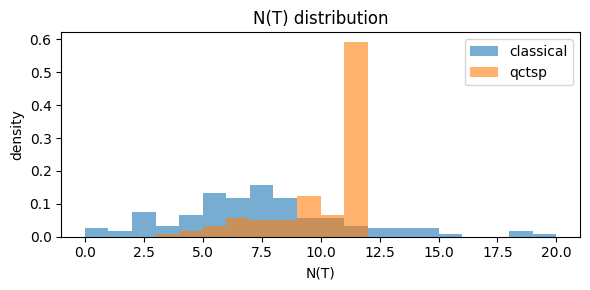

In [10]:
import numpy as np

c_samples = np.array(report["classical"]["N_T"]["samples"], dtype=int)
q_samples = np.array(report["qctsp"]["N_T"]["samples"], dtype=int)

max_bin = int(max(c_samples.max(initial=0), q_samples.max(initial=0)))
bins = np.arange(0, max_bin + 2)

try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 3))
    plt.hist(c_samples, bins=bins, alpha=0.6, label="classical", density=True)
    plt.hist(q_samples, bins=bins, alpha=0.6, label="qctsp", density=True)
    plt.xlabel("N(T)")
    plt.ylabel("density")
    plt.title("N(T) distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as exc:
    c_counts = np.bincount(c_samples, minlength=max_bin + 1)
    q_counts = np.bincount(q_samples, minlength=max_bin + 1)
    print("matplotlib unavailable; showing counts instead.")
    print("bins:", list(range(max_bin + 1)))
    print("classical counts:", c_counts.tolist())
    print("qctsp counts:", q_counts.tolist())


In [13]:
q_samples

array([11,  9, 11, 11, 11, 11, 11,  5,  9,  9, 11, 11,  9,  5, 11, 11,  9,
       10, 11, 11, 10, 11, 10, 11,  4, 10,  9, 11, 11, 11, 11,  5, 11, 11,
       11, 11, 11,  9, 11, 11,  6,  9, 11, 11, 11, 10,  7,  6,  6, 11,  9,
        3,  8, 11, 11, 11, 11,  9, 11,  8, 11,  8, 11, 11,  7, 11, 10, 11,
       11, 11,  9, 11, 11, 11, 11, 11,  5, 11,  7,  9,  7, 11, 11, 11, 11,
       11,  8,  7, 11,  9,  8, 11, 11, 11, 11, 11,  8, 11, 11, 11,  6,  9,
       11,  7, 11,  4, 11, 11, 11,  9, 11, 11,  6,  6, 10, 11, 10, 11,  6,
       11])

### 可視化（I_η / I_λ の平均・分散の比較）

古典HawkesとQCTSPの **積分指標（I_η, I_λ）** の平均・分散を棒グラフで比較します。
matplotlib が無い場合はテキスト表示にフォールバックします。


In [11]:
import numpy as np

metrics = {
    "I_eta_mean": (report["classical"]["I_eta"]["mean"], report["qctsp"]["I_eta"]["mean"]),
    "I_eta_var": (report["classical"]["I_eta"]["var"], report["qctsp"]["I_eta"]["var"]),
    "I_lambda_mean": (report["classical"]["I_lambda"]["mean"], report["qctsp"]["I_lambda"]["mean"]),
    "I_lambda_var": (report["classical"]["I_lambda"]["var"], report["qctsp"]["I_lambda"]["var"]),
}

labels = list(metrics.keys())
classical_vals = [metrics[k][0] for k in labels]
qctsp_vals = [metrics[k][1] for k in labels]

x = np.arange(len(labels))

try:
    import matplotlib.pyplot as plt

    width = 0.35
    plt.figure(figsize=(7, 3))
    plt.bar(x - width/2, classical_vals, width, label="classical")
    plt.bar(x + width/2, qctsp_vals, width, label="qctsp")
    plt.xticks(x, labels, rotation=30, ha="right")
    plt.ylabel("value")
    plt.title("I_eta / I_lambda summary")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    print("matplotlib unavailable; showing values instead.")
    for k in labels:
        print(k, "classical=", metrics[k][0], "qctsp=", metrics[k][1])


上の結果が極端に乖離している場合は、以下を疑ってください。

- **n_steps が小さすぎる** → N(T) が強制的に小さくなる
- **tau_edges / tau_repr のミスマッチ** → τ再構成のズレ
- **eta_max が小さすぎる** → ηの飽和/クリッピング

`ComparisonConfig` を少しずつ動かして、どの要因で差が縮むかを確認すると
論文の離散化誤差の議論（Section 3/4）とも整合します。


## Exercises

1. `tau_repr_mode` を midpoint / condexp に変えて、`tau_vals` がどう変わるか観察してください。
2. `beta` を大きくしたとき、遷移表 `trans` の変化を確認してください。
3. `S` を増やしたとき、回路のレジスタサイズがどう変わるか確認してください。


In [12]:
# 解答スケッチ（自由に編集）
# 例: tau_repr_mode の比較
# repr_mid = tau_bin_representative_midpoint(edges)
# repr_cond = tau_bin_representative_condexp(edges, rate=rate)
# print(repr_mid, repr_cond)


## Pitfalls / Extensions

Pitfalls:
- **n_steps が小さすぎる**と \(N(T)\) がほぼ一定になり、比較が歪む。
- **tau_edges / tau_repr の不整合**で p(τ|X) と再構成がずれる。
- Hawkes の \(\eta\) は連続値なので **Sが小さいと量子化誤差が大きい**。

Extensions:
- 論文の Fig.7 に対応する **振幅推定回路**を組み込み、量子側で I(X,T) を推定する。
- lookup 回路を改良して **深さ最適化**（論文 Table 2 の議論に近づける）。
- Hawkes の別カーネルや多次元拡張を同じ枠組みで離散化する。
